# Final Project 4990

In this project, we will build a machine learning model to predict the travel time of a taxi trip in New York City based on the New York City 2016 Taxi data. 

## 1. Data Gathering

Our data is mainly gathered from New York City 2016 Taxi data. To detect features, we combine two more dataset including the New York weather data and traffic accident data. After extracting all features, we remove the outliers and extreme points from the data. 

### 1.1 Big Query Data Extraction

#### Dataset Intrduction

In this project, we totally join three datasets(*Taxi, Weather, Collision*) to make final prediction of travel_time. According to our intuition, the travel time would be effected by weather and traffic condition, so we choose these two dataset. 

1. Taxi data

Variables selected: *pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, pickup_datetime, dropoff_datetime, travel_time(derived from dropoff_datetime and pickup_datetime), dayname*

2. Weather data

Variables selected: *visib, prcp, fog, rain_drizzle, snow_ice_pellets, hail*

3. Traffic collision data

Variables selected: *date_of_accident, longitude, latitude, timestamp*

#### Big Query(Taxi Data & Weather)

In [4]:
import pandas as pd
import os

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/hcy/Downloads/ecbm4040-ch3409-ab3a944860f8.json"

In [8]:
from google.cloud import bigquery
client = bigquery.Client()

## JOIN Taxi,Weather
query = (
"""
CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  111.045 * 180 * x / ACOS(-1)
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
    ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
);


SELECT * FROM
(
SELECT 
     pickup_latitude,
     pickup_longitude,
     dropoff_latitude,
     dropoff_longitude,
     TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
     pickup_datetime,
     dropoff_datetime,
     FORMAT_DATE('%A',EXTRACT(DATE FROM pickup_datetime)) as dayname,
     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
     EXTRACT (HOUR FROM pickup_datetime) as hour_of_day,
     CASE WHEN EXTRACT (HOUR FROM pickup_datetime) in (7,8,9,10,17,18,19,20) THEN 1
          ELSE 0
          END AS if_during_peek,
    HAVERSINE(dropoff_latitude,dropoff_longitude, dropoff_latitude, pickup_longitude) + HAVERSINE(dropoff_latitude,pickup_longitude, pickup_latitude, pickup_longitude) AS distance_in_km
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and dropoff_longitude IS NOT NULL and (HAVERSINE(dropoff_latitude,dropoff_longitude, dropoff_latitude, pickup_longitude) + HAVERSINE(dropoff_latitude,pickup_longitude, pickup_latitude, pickup_longitude))>0.1 and EXTRACT (YEAR FROM pickup_datetime)=2016
) a
INNER JOIN
(
 select concat(year,'-',mo,'-',da) as date_of_year2,visib,prcp,fog,rain_drizzle,snow_ice_pellets,hail
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) weather_data
on CAST(a.date_of_year AS STRING) = weather_data.date_of_year2 
LIMIT 1000000
""" )
df=pd.io.gbq.read_gbq(query,dialect='standard')
df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,travel_time,pickup_datetime,dropoff_datetime,dayname,date_of_year,hour_of_day,if_during_peek,distance_in_km,date_of_year2,visib,prcp,fog,rain_drizzle,snow_ice_pellets,hail
0,40.719234,-73.990921,40.756737,-73.873405,1189,2016-05-28 03:04:14+00:00,2016-05-28 03:24:03+00:00,Saturday,2016-05-28,3,0,14.049296,2016-05-28,7.7,0.00,0,0,0,0
1,40.770714,-73.947662,40.708187,-73.915367,2155,2016-01-24 16:56:32+00:00,2016-01-24 17:32:27+00:00,Sunday,2016-01-24,16,0,9.661783,2016-01-24,7.4,1.82,1,0,1,0
2,40.774204,-73.872955,40.731628,-73.988457,2050,2016-05-30 20:13:35+00:00,2016-05-30 20:47:45+00:00,Monday,2016-05-30,20,1,14.446934,2016-05-30,7.2,1.65,1,1,0,0
3,40.769749,-73.863647,40.747921,-73.993210,2977,2016-06-28 08:55:03+00:00,2016-06-28 09:44:40+00:00,Tuesday,2016-06-28,8,1,13.323477,2016-06-28,5.7,0.54,0,1,0,0
4,40.765320,-73.979980,40.728981,-73.874580,1148,2016-06-19 01:06:14+00:00,2016-06-19 01:25:22+00:00,Sunday,2016-06-19,1,0,12.904700,2016-06-19,9.4,0.00,0,0,0,0


#### Big Query(Collision Data)

In [9]:
# Extract Collision Data
query = (
"""
SELECT EXTRACT (DATE FROM timestamp) as date_of_accident,longitude,latitude,timestamp
FROM `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions` 
WHERE EXTRACT (YEAR FROM timestamp) = 2016 and (EXTRACT (MONTH FROM timestamp) in (1,2,3,4,5,6))
""")
df_2=pd.io.gbq.read_gbq(query,dialect='standard')
df_2.head()

,date_of_accident,longitude,latitude,timestamp
0,2016-05-15,-73.882744,40.816864,2016-05-15 06:40:00
1,2016-02-13,-73.804000,40.760272,2016-02-13 09:50:00
2,2016-03-19,-74.009040,40.713560,2016-03-19 22:25:00
3,2016-04-28,-73.917550,40.728400,2016-04-28 00:00:00
4,2016-01-10,-73.917752,40.743046,2016-01-10 00:30:00


### 1.2 Feature Extraction

After getting original data from BigQuery, we need to extract some features for future need. The extracted features are as followings:

1. Convert Day name to one hot encoded dummy variables

2. if_during_peak : we split 24 hours into two period, one is peak period include(7,8,9,10,17,18,19,20), for which the traffic is heavy,the left is normal period, for which traffic is light.

3. Travel Distance : we use Manhattan distance to compute the length of route given the location of pickup area and dropoff area.

4. 30_minute_before_pickup : this variable is a 30 minutes earlier timestamp of pickup_datetime

5. number_of_accident : the number of accidents during the 30 minutes before pickup_datetime


In [20]:
# Convert Day name to one hot encoded dummy variable
import numpy as np

if_Monday = np.zeros([df.shape[0],1])
if_Tuesday = np.zeros([df.shape[0],1])
if_Wednesday = np.zeros([df.shape[0],1])
if_Thursday = np.zeros([df.shape[0],1])
if_Friday = np.zeros([df.shape[0],1])
if_Saturday = np.zeros([df.shape[0],1])
for i in range(df.shape[0]):
    if df['dayname'].iloc[i] == 'Monday': if_Monday[i] = 1
    elif df['dayname'].iloc[i] == 'Tuesday': if_Tuesday[i] = 1
    elif df['dayname'].iloc[i] == 'Wednesday': if_Wednesday[i] = 1
    elif df['dayname'].iloc[i] == 'Thursday': if_Thursday[i] = 1
    elif df['dayname'].iloc[i] == 'Friday': if_Friday[i] = 1
    elif df['dayname'].iloc[i] == 'Saturday': if_Saturday[i] = 1 
df['if_Monday'] = if_Monday
df['if_Tuesday'] = if_Tuesday
df['if_Wednesday'] = if_Wednesday
df['if_Thursday'] = if_Thursday
df['if_Friday'] = if_Friday
df['if_Saturday'] = if_Saturday

In [ ]:
# Add a column, 30_minute_before_pickup
from datetime import timedelta
df['30_minute_before_pickup'] = df['pickup_datetime'] - timedelta(minutes=30)

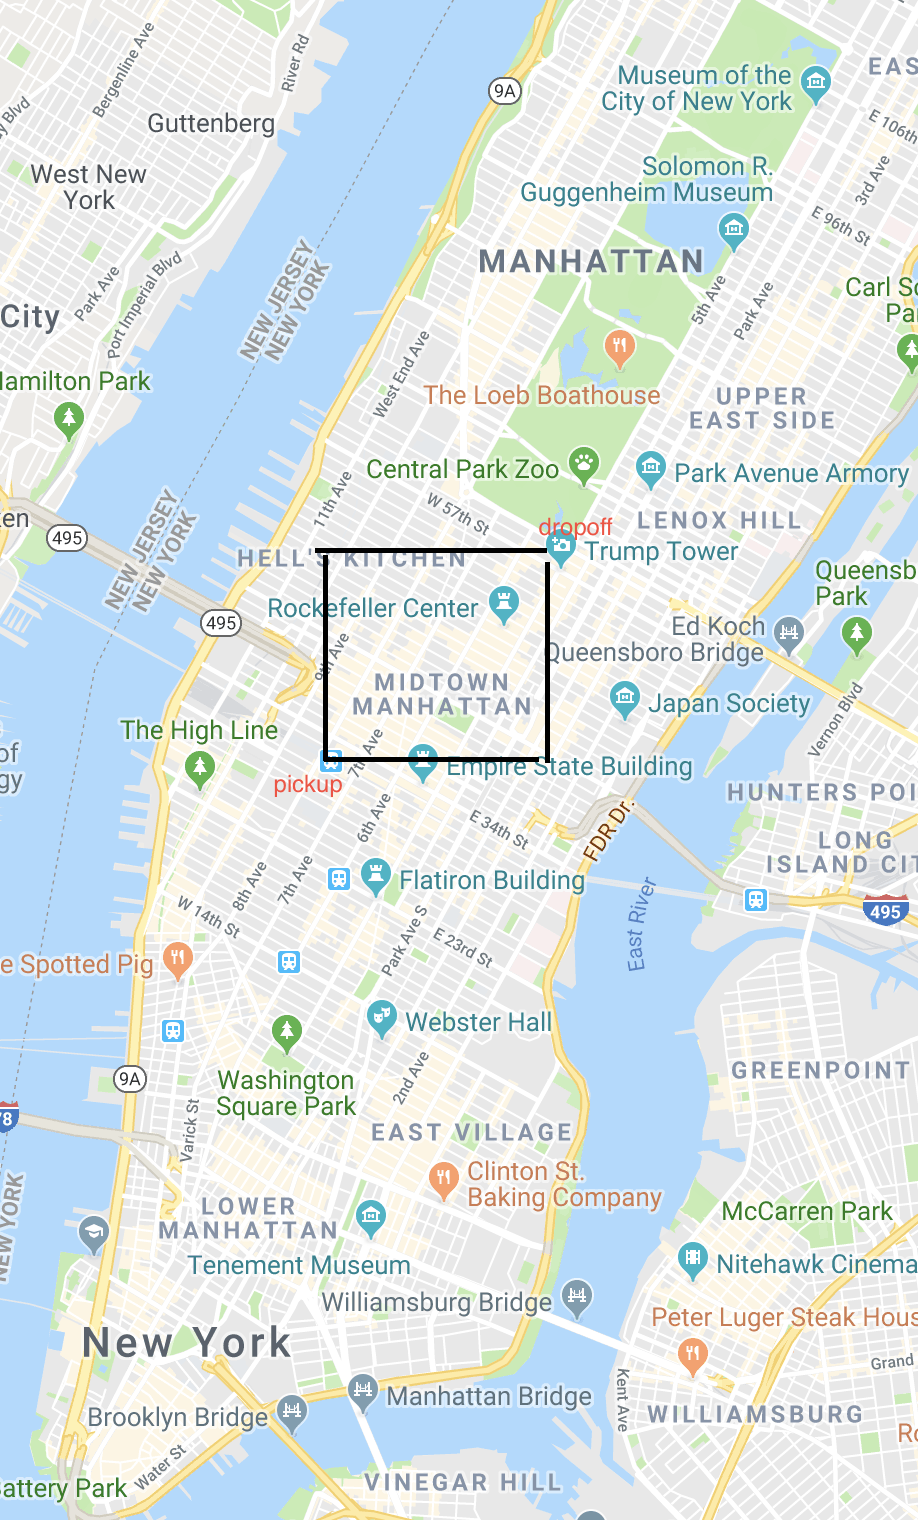

In [7]:
# Import an image
from IPython.display import Image
Image('/Users/hcy/Desktop/NYC.png',width=500,height=400)

Here, the image is to illustrate how we count the number of accidents happened during 30 minutes before pickup time within a block.

### 1.3 Remove Outliers

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

First, let's have a look at the **distance** and **travel_time** to find whether there are outliers in these two variables.

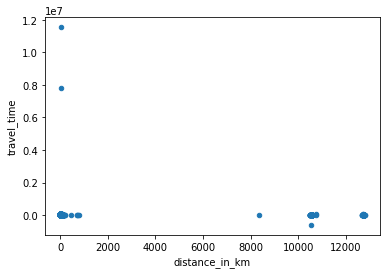

In [83]:
# Plot (distance vs. travel_time)
df.plot(x='distance_in_km',y='travel_time',kind='scatter')

From the scatter plot, we can find there might be some outliers for which **the distance_in_km** $>10000$ and **travel_time** $>10000$. It's almost impossible to happen, therefore, we remove these data. Here, the reason why we control the **travel_time** to be $< 2000$,which is roughly equal to $35$ minutes, is that we find most of our data is in this area, so we only consider these data.

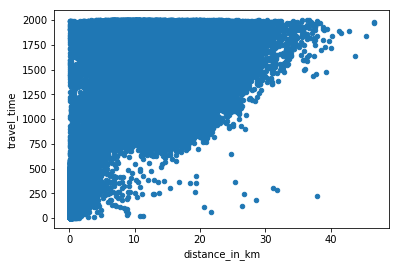

In [27]:
# Filter the outliers in 'distance' and 'travel_time'
df_filtered=df[(df['travel_time']>0) & (df['distance_in_km']<50)  & (df['travel_time']<2000)]
df_filtered.plot(x='distance_in_km',y='travel_time',kind='scatter')

After filtering the dataset, the remaining data seems more reasonable. Next, we ues similar procedure to find whether there are outliers for other variables. First, let's take a look at the **latitude** and **longitude** of the pickup and dropoff place.

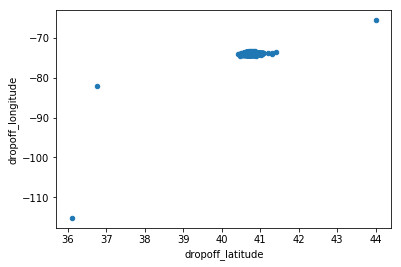

In [30]:
df_filtered.plot(x='dropoff_latitude',y='dropoff_longitude',kind='scatter')

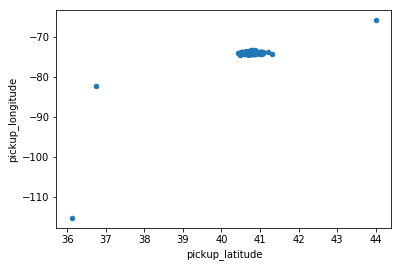

In [32]:
df_filtered.plot(x='pickup_latitude',y='pickup_longitude',kind='scatter')

From the plot, we can find some latitude and longitude are not exactly in the New York City, for which the latitude should be around $40.730610$, and longitude should be around $73.935242$. Therefore, we remove the data for which the longitude $<-80$ or $>-70$. 

Text(0.5,1,'Histogram of dropoff_longitude')

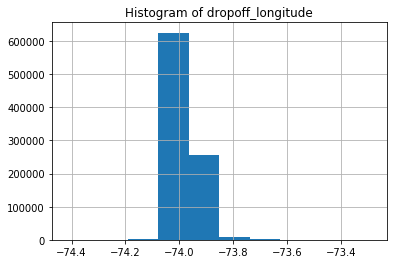

In [33]:
df_filtered_1 = df_filtered[(df_filtered['dropoff_longitude']>-80) & (df_filtered['dropoff_longitude']< -70) & (df_filtered['pickup_longitude']>-80) & (df_filtered['pickup_longitude']< -70)]
df_filtered_1['dropoff_longitude'].hist()
plt.title('Histogram of dropoff_longitude')

Then, we look at the weather variables, which include **visibility**, **fog**, **precipitation**, **snow**, **hail** 

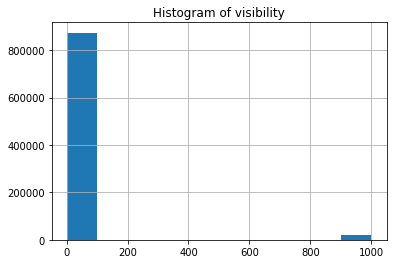

In [42]:
# Histogram of visibility 
df_filtered['visib'].hist()
plt.title('Histogram of visibility')

# Remove the outliers in visibility
df_filtered_2 = df_filtered_1[df_filtered_1['visib']<200]

By drawing the histogram plot of visibility, we can see some extreme points for which the values of visibility are more than 800, so we remove these extreme points.

Besides, some weather variables are categorical and it's hard to say there are outliers in these variables. Therefore, we use some tables to get a overview of these variables.

In [41]:
print(df_filtered_2['fog'].value_counts())
print(df_filtered_2['snow_ice_pellets'].value_counts())
print(df_filtered_2['hail'].value_counts())

0    854869
1     38762
Name: fog, dtype: int64
0    825780
1     67851
Name: snow_ice_pellets, dtype: int64
0    893631
Name: hail, dtype: int64


We found the values of variable **hail** are all the same. The reason is that the dataset only contains data from 2016 Jan to 2016 Jun, during which period there isn't hail. As a result, we remove this variable from our training set because it can't improve the performance of our model.

Till now, we finally have the clean dataset which can be used for our model !

In [79]:
# Final Dataset
df_train = df_filtered_2[['travel_time','distance_in_km','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pickup_datetime','30_minute_before_pickup','if_Monday','if_Tuesday', 'if_Wednesday',
       'if_Thursday', 'if_Friday', 'if_Saturday','if_during_peek','visib','fog','prcp','snow_ice_pellets']]

In [80]:
df_train.shape

(873793, 19)

In [81]:
df_train.head()

,travel_time,distance_in_km,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_datetime,30_minute_before_pickup,if_Monday,if_Tuesday,if_Wednesday,if_Thursday,if_Friday,if_Saturday,if_during_peek,visib,fog,prcp,snow_ice_pellets
0,1189,14.049296,40.719234,-73.990921,40.756737,-73.873405,2016-05-28 03:04:14+00:00,2016-05-28 02:34:14+00:00,0.0,0.0,0.0,0.0,0.0,1.0,0,7.7,0,0.0,0
4,1148,12.904700,40.765320,-73.979980,40.728981,-73.874580,2016-06-19 01:06:14+00:00,2016-06-19 00:36:14+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,9.4,0,0.0,0
6,1770,9.617488,40.722301,-74.008026,40.786289,-73.978149,2016-06-20 18:02:29+00:00,2016-06-20 17:32:29+00:00,1.0,0.0,0.0,0.0,0.0,0.0,1,8.9,0,0.0,0
7,1702,18.033233,40.740547,-73.998154,40.851570,-73.930237,2016-06-19 05:45:03+00:00,2016-06-19 05:15:03+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,9.4,0,0.0,0
10,1578,7.649165,40.769279,-73.989052,40.715061,-74.008400,2016-06-26 01:25:03+00:00,2016-06-26 00:55:03+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,9.0,0,0.0,0


In [82]:
# Export Data to csv file
Train_Data_csv = df_train.to_csv(r'/Users/hcy/Desktop/train_data.csv',index=False)

In [75]:
Train_Data_2_csv = df_2.to_csv(r'/Users/hcy/Desktop/train_data_2.csv',index=False)

In [77]:
Original_Data_csv = df.to_csv(r'/Users/hcy/Desktop/original_data.csv',index=False)

## 2. Exploratory Analysis

At this part, we do exploratory data analysis to see the relationship between the variable we selected and travel time. First, we can look at the correlation matrix of dataset.

In [57]:
df_train.corr()

,travel_time,distance_in_km,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,if_Monday,if_Tuesday,if_Wednesday,if_Thursday,if_Friday,if_Saturday,if_during_peek,visib,prcp
travel_time,1.000000,0.866245,-0.140807,0.325434,-0.122894,0.337474,-0.004008,-0.000586,0.002704,0.009878,0.002704,-0.018006,-0.060756,0.000867,-0.000108
distance_in_km,0.866245,1.000000,-0.166063,0.421274,-0.047239,0.403802,0.007091,-0.007682,-0.010873,-0.007274,-0.008359,-0.010925,-0.087966,0.002790,0.004694
pickup_latitude,-0.140807,-0.166063,1.000000,0.079772,0.562041,0.059488,0.009119,0.007588,0.009437,0.007228,0.006868,-0.019946,0.061123,0.001446,-0.002518
pickup_longitude,0.325434,0.421274,0.079772,1.000000,0.047163,0.410304,0.025865,0.006913,-0.003123,-0.007259,-0.007387,-0.026964,-0.002580,-0.002462,0.012611
dropoff_latitude,-0.122894,-0.047239,0.562041,0.047163,1.000000,0.294754,0.001730,0.003234,0.004710,0.004755,0.004686,-0.009789,0.032411,0.000719,-0.003748
dropoff_longitude,0.337474,0.403802,0.059488,0.410304,0.294754,1.000000,0.001861,-0.004831,-0.002073,-0.000873,0.005392,-0.011499,-0.045786,-0.000188,0.000678
if_Monday,-0.004008,0.007091,0.009119,0.025865,0.001730,0.001861,1.000000,-0.159882,-0.156484,-0.162289,-0.167963,-0.165955,0.029339,-0.113618,0.112940
if_Tuesday,-0.000586,-0.007682,0.007588,0.006913,0.003234,-0.004831,-0.159882,1.000000,-0.160042,-0.165978,-0.171782,-0.169728,0.033606,-0.072800,0.048497
if_Wednesday,0.002704,-0.010873,0.009437,-0.003123,0.004710,-0.002073,-0.156484,-0.160042,1.000000,-0.162451,-0.168131,-0.166120,0.026648,-0.046466,-0.015126
if_Thursday,0.009878,-0.007274,0.007228,-0.007259,0.004755,-0.000873,-0.162289,-0.165978,-0.162451,1.000000,-0.174368,-0.172283,0.018714,0.125076,0.013583


We can see travel time is highly correlated with the travel distance and location of pickup and dropoff, which is consistent with our expectation. Besides, the number of accidents during the 30 minutes before pickup time and if_during_peak are also good variables. It's easy to interpret because if it's during peak period the traffic is heavy,so the travel time would be longer than normal in our common sense. Similarly, if the number of accidents happend in that period is large, which means the traffic flow might stagnate, the travel time would be longer as well.

However, some variables are not as good as we expect, such as the dayname variables and weather variables. Even though these variables seem bad, we still put them in our original model. In the model selection part, we use some variable selection methods to exclude part of them to improve our model performance.

Next,we draw some plots to make it easy to know the relationship between these variables with travel time.

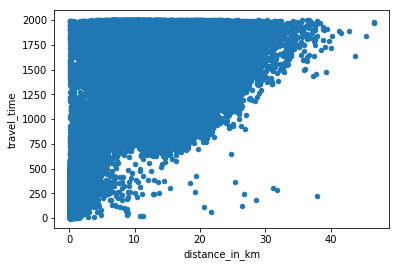

In [84]:
# plot Distance vs. Travel_time
df_train.plot(x='distance_in_km',y='travel_time',kind='scatter')

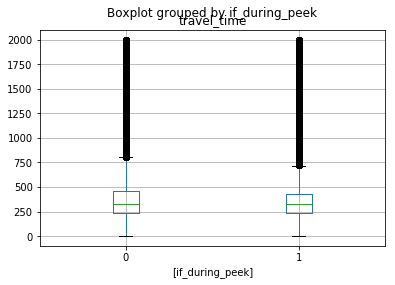

In [90]:
df_train[['travel_time','if_during_peek']].boxplot(by='if_during_peek')

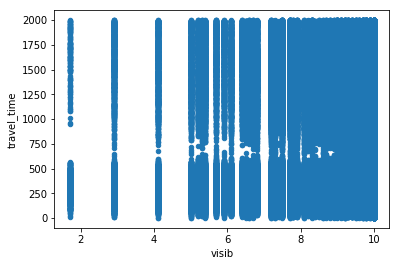

In [91]:
# plot Visibility vs. Travel_time
df_train.plot(x='visib',y='travel_time',kind='scatter')

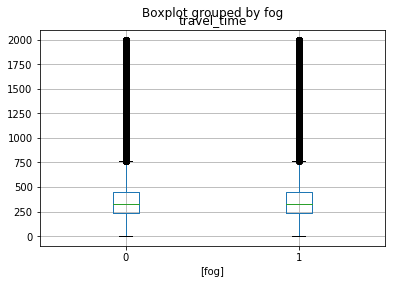

In [92]:
df_train[['travel_time','fog']].boxplot(by='fog')

From the plots showed above, we could get some general understanding of our dataset which is necessary for our future analysis and model building.

## 3. Model construction and comparision

In this part, we build different machine learning models including linear regression, random forest and boosting to predict the travel time. Compare all the models and choose the best one as our final model.  

First we devide the data into training and testing part. The training part is used to train the model and the testing part is used to evaluate the performance of the model.

In [81]:
import pandas as pd
dat = pd.read_csv("/Users/weiyaofan/Desktop/train_dataset_1.csv")

# Selected Variables 
x = dat[['distance_in_km','if_Monday','if_Tuesday','if_Wednesday','if_Thursday','if_Friday','if_Saturday','if_during_peek','visib','fog','prcp','snow_ice_pellets','num_accident']]
# Y
y = dat[['travel_time']]

In [82]:
#Train and test data split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

### 3.1 Linear Regression

In this part, an ordinary least square model will be built and the t-test will be used to see the importance of each feature. Then we apply the shrinkage methods including Lasso and Ridge to see whether they can improve the linear model.

Since the latitude and longitude are not appropriate in the linear model, we only use the distance computed from latitude and longitude here. The num_accident variable also contains some information about start and end point.

#### 3.1.1 Ordinary Least Square

First, we build a ordinary least square model.

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression

linear_mod = LinearRegression()
linear_mod.fit(x_train,y_train)
linear_mod.score(x_test,y_test)

0.7519296881784828

Then we want to use t-test to show the p_value of each variable.

In [7]:
import scipy, scipy.stats
import statsmodels.api as sm

result = sm.OLS(y_train, x_train).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            travel_time   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                 4.278e+05
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        08:32:52   Log-Likelihood:            -4.8373e+06
No. Observations:              699034   AIC:                         9.675e+06
Df Residuals:                  699022   BIC:                         9.675e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
distance_in_km      91.3474      0.075   1224.135      0.000      91.201      91.494
if_Monday           13.2315      0.977     13.548      0.000      11.317      15.146
if_Wednesday        41.6096      0.957     43.495      0.000      39.735      43.485
if_Thursday         34.6253      0.956     36.204      0.000      32.751      36.500
if_Friday           34.8469      0.927     37.596      0.000      33.030      36.664
if_Saturday         13.0461      0.935     13.948      0.000      11.213      14.879
if_during_peek      19.7132      0.596     33.052      0.000      18.544      20.882
visib               18.5631      0.069    270.765      0.000      18.429      18.697
fog                 26.0610      1.650     15.792      0.000      22.827      29.296
prcp                32.9067      1.324     24.861      0.000      30.312      35.501
snow_ice_pellets     4.5428      1.197      3.795      0.000       2.197       6.889
num_accident        31.1653      0.629     49.525      0.000      29.932      32.399
==============================================================================
Omnibus:                   181100.823   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1613726.259
Skew:                           0.996   Prob(JB):                         0.00
Kurtosis:                      10.172   Cond. No.                         63.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can find from the summary all the p_values of the coefficients are smaller than 0.05 which means all the coefficients are not equal to 0. In the next step, we hope to use shrinkage methods to get a better result.

#### 3.1.2 Lasso Regression

We scale the train and test data seperately to make it reasonable in the Lasso regression (also Ridge regression). For convenience to other generated data, we build a function to scale x and y.

In [8]:
#function scale_dat, Input: x, y, output: x_scaled, y_scaled
from sklearn import preprocessing

def scale_dat(x ,y):
    x_scaled = preprocessing.scale(x)
    y_scaled = y - np.mean(y)
    return x_scaled, y_scaled

In [9]:
#scale the train and test set
x_train_scale, y_train_scale = scale_dat(x_train, y_train)
x_test_scale, y_test_scale = scale_dat(x_test, y_test)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


Use 5 fold cross validation to determine the optimal value of alpha:

In [31]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

#Use cross validation to find the best alpha
alphas = np.linspace(0.01, 0.3, 1000)
dic_alphas = dict(alpha = alphas)
grid_search = GridSearchCV(Lasso(), dic_alphas, scoring = 'r2',n_jobs = -1,cv = 5)
grid_result = grid_search.fit(x_train_scale, y_train_scale)
alpha_opt = grid_result.best_params_
print alpha_opt

{'alpha': 0.02161161161161161}


Based on the best alpha build the Lasso model:

In [33]:
#Use the optimal alpha to build the Lasso Model
Lasso_mod = Lasso(alpha =0.02161161161161161)
Lasso_mod.fit(x_train_scale,y_train_scale)
Lasso_mod.score(x_test_scale,y_test_scale)

0.7519269045247712

In [35]:
Lasso_mod.coef_

array([ 4.15932509e+02, -2.29573164e-02,  8.23483962e+00,  1.05532821e+01,
        7.99321647e+00,  3.03414530e-01,  6.68255569e+00, -3.62805516e+00,
       -1.53875588e+00, -1.97179192e+00, -3.22272374e+00,  1.74262746e+01])

Based on the results from the cross validation we apply the optimal alpha to Lasso model. However, the test accuracy doesn't change significantly. When we show the coefficients of the Lasso model, we can find that Lasso model does not shrinkage any coefficients to 0.

#### 3.1.3 Ridge Regeression 

Use cross validation to determine the optimal value of alpha

In [39]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

#Use cross validation to find the best alpha
alphas = np.linspace(15, 25, 1000)
dic_alphas = dict(alpha = alphas)
grid_search = GridSearchCV(Ridge(), dic_alphas, scoring = 'r2',n_jobs = -1,cv = 5)
grid_result = grid_search.fit(x_train_scale, y_train_scale)
alpha_opt = grid_result.best_params_
print alpha_opt

{'alpha': 21.206206206206204}


Based on the best alpha build the Ridge model

In [40]:
#Use the optimal alpha to build the Lasso Model
Ridge_mod = Ridge(alpha = 21.206206206206204)
Ridge_mod.fit(x_train_scale,y_train_scale)
Ridge_mod.score(x_test_scale,y_test_scale)

0.7519270684397891

In [41]:
Ridge_mod.coef_

array([[ 4.15935124e+02, -1.16697606e-02,  8.27653088e+00,
         1.06029630e+01,  8.03953286e+00,  3.49689827e-01,
         6.70412786e+00, -3.67579679e+00, -1.55561389e+00,
        -1.99742007e+00, -3.24106065e+00,  1.74462404e+01]])

Based on the optimal alpha from the cross validation, we find that the $R^2$ is only slightly better than the OLS. In the next part, we will plot the three $R^2$ and the coefficients of Lasso and Ridge.

#### 3.1.4 Comparison and Analysis on Linear Models

First we polt the $R^2$ based on trainning set and test set for the above three models.

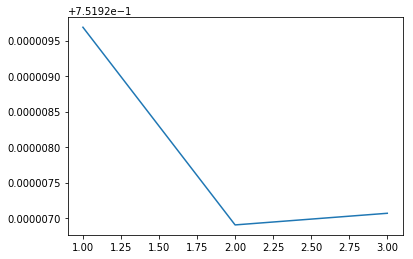

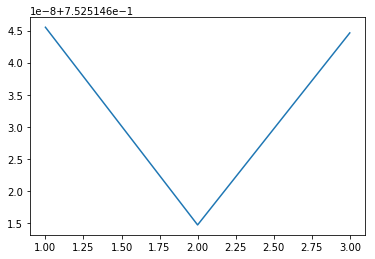

In [89]:
temp = [1,2,3]
test_rsq = [linear_mod.score(x_test,y_test), Lasso_mod.score(x_test_scale,y_test_scale), Ridge_mod.score(x_test_scale,y_test_scale)]
train_rsq = [linear_mod.score(x_train,y_train), Lasso_mod.score(x_train_scale,y_train_scale), Ridge_mod.score(x_train_scale,y_train_scale)]
plt.plot(temp, test_rsq)
plt.show()
plt.plot(temp, train_rsq)
plt.show()

We can see from the plot that the OLS achieves the highest test $R^2$

Then we plot the coefficients of Lasso and try to find the importance of each features:

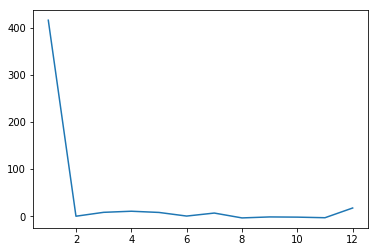

In [96]:
plt.plot(np.linspace(1,13,13),Lasso_mod.coef_)
plt.show()

From the plot we can find that the coefficients of distance are the highest one compared to other features. Apart from distance, num_accident are relatively high among other features.

Since we don't use the pickup and dropoff latitude and longitude here, we are highly possiable to loose some information. Even though the latitude and longitude are not suitable for the linear model based on their cycle characteristic, but in the area of New York the overlap will never occur. So we consider introduce the latitude and longitude in the model just as the start and end line and hope to see whether it will affect the liner model.

In [97]:
from sklearn.model_selection import train_test_split
x = dat[['pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude','distance_in_km','if_Monday','if_Wednesday','if_Thursday','if_Friday','if_Saturday','if_during_peek','visib','fog','prcp','snow_ice_pellets','num_accident']]
y = dat[['travel_time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [98]:
linear_mod_test = LinearRegression()
linear_mod_test.fit(x_train,y_train)
linear_mod_test.score(x_test,y_test)

0.7661755612283158

It's interesting that the test $R^2$ do rise around 0.01. However for safety, we do not consider this model in the following comparision.

### 3.2 Random Forest

Since the random forest is not a linear model, we add the pickup and dropoff latitude and longitude into x.

In [99]:
x = dat[['pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude','distance_in_km','if_Monday','if_Wednesday','if_Thursday','if_Friday','if_Saturday','if_during_peek','visib','fog','prcp','snow_ice_pellets','num_accident']]
y = dat[['travel_time']]

In [100]:
#Train and test data split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

Then we use cross validation to determine the optimal hyper-parameters of the random forest. We consider three hyper-parameters including n_estimators, max_depth and max_features. However among all the three, we think the max_depth will not significantly affect the performance of random forest because even though we grow a full tree, the random choice of feature will prevent the overfitting problem. But anyway we still tune all the three features.

In [57]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#Use cross validation to find the best hyper-parameter
max_depth = [7,17,27,37,47]
max_features = [6,7,8,9,10,11,12,13,14]
n_estimators = [100,200,300]

dic_para = dict(max_depth = max_depth, max_features = max_features, n_estimators = n_estimators)
grid_search = GridSearchCV(RandomForestRegressor(), dic_para, scoring = 'r2', n_jobs = -1,cv = 3)
grid_result = grid_search.fit(x_train, y_train.values.ravel())
para_opt = grid_result.best_params_
print para_opt

{'max_features': 12, 'n_estimators': 200, 'max_depth': 37}


Build the Random Forest based on the optimal parameters:

In [51]:
Rf_mod = RandomForestRegressor(n_estimators=200, max_features = 12, max_depth = 37, random_state=0)
Rf_mod.fit(x_train,y_train.values.ravel())
print Rf_mod.score(x_test,y_test)

0.9209255118930317


In [ ]:
print Rf_mod.score(x_train,y_train)

The test $R^2$ is better than linear model. The training $R^2$ is extremely high. Then we plot the importance of each features.

Index([u'pickup_latitude', u'pickup_longitude', u'dropoff_latitude',
       u'dropoff_longitude', u'distance_in_km', u'if_Monday', u'if_Wednesday',
       u'if_Thursday', u'if_Friday', u'if_Saturday', u'if_during_peek',
       u'visib', u'fog', u'prcp', u'snow_ice_pellets', u'num_accident'],
      dtype='object')
[1.69907898e-02 2.66490946e-02 2.02310683e-02 3.37812247e-02
 8.24912636e-01 9.53033903e-04 1.06469010e-03 1.21719097e-03
 1.12249937e-03 1.14877801e-03 1.67390679e-03 5.29998328e-03
 3.49454703e-04 3.98767420e-03 5.95389366e-04 6.00225855e-02]


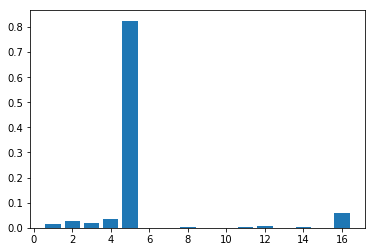

In [66]:
#Plot the feature importance
temp = np.linspace(1,17,17)
plt.bar(temp,Rf_mod.feature_importances_)
print x.columns
print Rf_mod.feature_importances_

We can find that the distance almost dominates in the plot which can be treated as the most important feature. To clearly show other features, we do another plot without distance.

<BarContainer object of 15 artists>

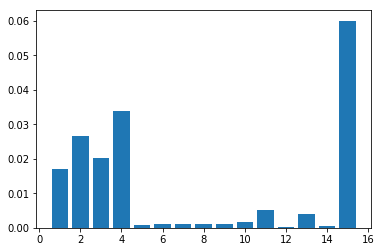

In [77]:
#Plot the importance without the distance feature
temp = np.linspace(1,16,16)
plt.bar(temp,Rf_mod.feature_importances_[[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16]])

Apart from the distance feature, the num_accident and latitude and longitude are reletively high from the plot. However, the features related to weather are not very significant. Also weekdays are not significant here.

### 3.3 AdaBoost

Similar to random forest, we use cross validation to determine the optimal value hyper-parameters in Adaboosting. Here we tune the hyper-parameter of n_estimators and learning_rate. There is a trade-off between the two hyperparameters which means the smaller learning rate may need a larger n. The default tree with 2 depth are used.

In [103]:
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#Use cross validation to find the best hyper-parameter

n_estimators = [100, 200, 300, 400]
learning_rate = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85,0.95]

dic_para = dict(learning_rate = learning_rate, n_estimators = n_estimators)
grid_search = GridSearchCV(AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=2)), dic_para, scoring = 'r2', n_jobs = -1,cv = 3)
grid_result = grid_search.fit(x_train, y_train.values.ravel())
para_opt = grid_result.best_params_
print para_opt

{'n_estimators': 200, 'learning_rate': 0.75}


Build the Adaboost model based on the optimal parameters:

In [108]:
Boost_mod = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=2) , n_estimators = 200, learning_rate = 0.75, random_state=0)
Boost_mod.fit(x_train,y_train.values.ravel())
Boost_mod.score(x_test,y_test)

0.8759083746932945

In [116]:
Boost_mod.score(x_train,y_train)

0.8762536162325496

We can find that the test $R^2$ is better than OLS but smaller than Random Forest

Then we try to see the feature importance in the boosting model

In [115]:
print Boost_mod.feature_importances_

[0.         0.00559113 0.00731241 0.         0.98709646 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


We can find that the only three features are used in the adaboost model. Like before, the distance is still dominant feature. The latitude and longitude are not significant from the output

### 3.4 Comparision

We want to compare the OLS, Random Forest and Adaboost based on $RMSE, RMSLE, R^2$ on test data and train data. Choose the one which gives us the best performance in test set.

In [119]:
from sklearn.metrics import mean_squared_error

In [118]:
x_l = dat[['distance_in_km','if_Monday','if_Wednesday','if_Thursday','if_Friday','if_Saturday','if_during_peek','visib','fog','prcp','snow_ice_pellets','num_accident']]
y_l = dat[['travel_time']]
xl_train, xl_test, yl_train, yl_test = train_test_split(x_l, y_l, test_size=0.2, random_state=7)

In [150]:
Train_Err_RMSE = [np.sqrt(mean_squared_error(linear_mod.predict(xl_train),yl_train)), np.sqrt(mean_squared_error(Rf_mod.predict(x_train),y_train)), np.sqrt(mean_squared_error(Boost_mod.predict(x_train),y_train))]
Train_Err_RMSE

[243.52891170831128, 51.54148983296598, 172.20352387515692]

In [151]:
Test_Err_RMSE = [np.sqrt(mean_squared_error(linear_mod.predict(xl_test),yl_test)), np.sqrt(mean_squared_error(Rf_mod.predict(x_test),y_test)), np.sqrt(mean_squared_error(Boost_mod.predict(x_test),y_test))]
Test_Err_RMSE

[243.04659587889, 137.22092451145772, 171.8990129040579]

Text(0.5,1,'RMSE')

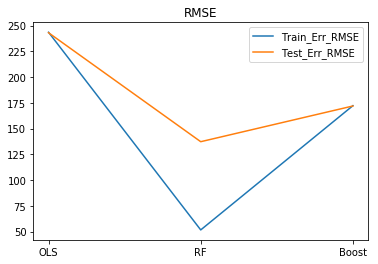

In [152]:
plt.plot(['OLS','RF','Boost'],Train_Err_RMSE)
plt.plot(['OLS','RF','Boost'],Test_Err_RMSE)
plt.legend(['Train_Err_RMSE','Test_Err_RMSE'])
plt.title("RMSE")

In [153]:
Train_Err_RMSLE = [np.sqrt(mean_squared_error(np.log(linear_mod.predict(xl_train)),np.log(yl_train))), np.sqrt(mean_squared_error(np.log(Rf_mod.predict(x_train)),np.log(y_train))), np.sqrt(mean_squared_error(np.log(Boost_mod.predict(x_train)),np.log(y_train)))]
Train_Err_RMSLE

[0.4387411499299139, 0.15160513545020085, 0.44630115819241967]

In [154]:
Test_Err_RMSLE = [np.sqrt(mean_squared_error(np.log(linear_mod.predict(xl_test)),np.log(yl_test))), np.sqrt(mean_squared_error(np.log(Rf_mod.predict(x_test)),np.log(y_test))), np.sqrt(mean_squared_error(np.log(Boost_mod.predict(x_test)),np.log(y_test)))]
Test_Err_RMSLE

[0.43743603716557744, 0.33421121128177533, 0.4451781086021028]

Text(0.5,1,'RMSLE')

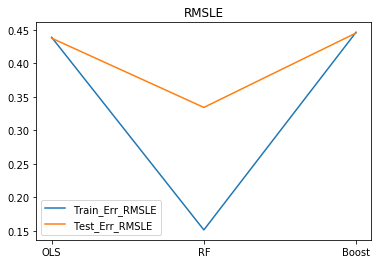

In [155]:
plt.plot(['OLS','RF','Boost'],Train_Err_RMSLE)
plt.plot(['OLS','RF','Boost'],Test_Err_RMSLE)
plt.legend(['Train_Err_RMSLE','Test_Err_RMSLE'])
plt.title("RMSLE")

In [157]:
Train_Err_Rsq = [linear_mod.score(xl_train, yl_train), Rf_mod.score(x_train, y_train), Boost_mod.score(x_train, y_train)]
Train_Err_Rsq

[0.7525146455177828, 0.9889143188401596, 0.8762536162325496]

In [158]:
Test_Err_Rsq = [linear_mod.score(xl_test, yl_test), Rf_mod.score(x_test, y_test), Boost_mod.score(x_test, y_test)]
Test_Err_Rsq

[0.7519296881784828, 0.9209255118930317, 0.8759083746932945]

Text(0.5,1,'Rsq')

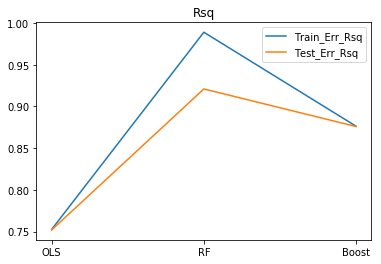

In [159]:
plt.plot(['OLS','RF','Boost'],Train_Err_Rsq)
plt.plot(['OLS','RF','Boost'],Test_Err_Rsq)
plt.legend(['Train_Err_Rsq','Test_Err_Rsq'])
plt.title("Rsq")

Random Forest model performs best among all three models. So we choose the Random Forest as our final model.

In [ ]:
import pickle
#This step is just to save a model
# save the model to disk
filename = '/Users/weiyaofan/Desktop/final_model.sav'
pickle.dump(Rf_mod, open(filename, 'wb'))

## 4. Prediction on test set

In this section, we are going to make prediction on the testset with our built model. 

### 4.1 Join Dataset

At this part, the first thing we need to do is to join the datasets we need for prediction, which include weather data and collision data in 2015.

In [2]:
# load test data
import pandas as pd
test = pd.read_csv('/Users/hcy/Downloads/APM4990_final_test_data_filtered.csv')
test.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
0,2015-06-18 21:52:45+00:00,40.702740,-74.011650,40.773361,-73.990311,5
1,2015-11-08 02:22:25+00:00,40.733608,-74.003098,40.836803,-73.941643,1
2,2015-02-13 04:11:11+00:00,40.730911,-74.001442,40.665699,-73.956909,1
3,2015-07-23 09:14:04+00:00,40.774078,-73.874550,40.749939,-73.991203,2
4,2015-01-07 18:06:43+00:00,40.791588,-73.964874,40.792084,-73.968254,2


In [6]:
# load weather data in 2015
query=(
"""
select concat(year,'-',mo,'-',da) as date_of_year2,visib,prcp,fog,snow_ice_pellets
from `bigquery-public-data.noaa_gsod.gsod2015` 
where stn='725053'
""")
df_weather_test=pd.io.gbq.read_gbq(query,dialect='standard')

# load collision data in 2015
query = (
"""
SELECT EXTRACT (DATE FROM timestamp) as date_of_accident,longitude,latitude,timestamp
FROM `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions` 
WHERE (EXTRACT (YEAR FROM timestamp) = 2015) and latitude is  not NULL and longitude is not NULL and timestamp is not NULL
""")
df_collision_test=pd.io.gbq.read_gbq(query,dialect='standard')

In [7]:
# Join dataset

# Convert the type of pickup_time into datetime
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
# Add a date column which would by used when joining tables 
test['date'] = test['pickup_datetime'].dt.date
# Add a hour column
test['hour'] = test['pickup_datetime'].dt.hour
# Add a dayname column
test['dayname'] = test['pickup_datetime'].dt.dayofweek

# merge taxi and weather data
df_weather_test['date_of_year2'] = pd.to_datetime(df_weather_test['date_of_year2']).dt.date

test_df = pd.merge(test, df_weather_test, how='left', left_on = ['date'], right_on = ['date_of_year2'] ).fillna(0)

In [12]:
# Feature Extraction

# dayname variable
n1 = test_df.shape[0]
if_Monday = np.zeros([n1,1])
if_Tuesday = np.zeros([n1,1])
if_Wednesday = np.zeros([n1,1])
if_Thursday = np.zeros([n1,1])
if_Friday = np.zeros([n1,1])
if_Saturday = np.zeros([n1,1])
for i in range(n1):
    if test_df['dayname'].iloc[i] == 1: if_Monday[i] = 1
    elif test_df['dayname'].iloc[i] == 2: if_Tuesday[i] = 1
    elif test_df['dayname'].iloc[i] == 3: if_Wednesday[i] = 1
    elif test_df['dayname'].iloc[i] == 4: if_Thursday[i] = 1
    elif test_df['dayname'].iloc[i] == 5: if_Friday[i] = 1
    elif test_df['dayname'].iloc[i] == 6: if_Saturday[i] = 1 
test_df['if_Monday'] = if_Monday
test_df['if_Tuesday'] = if_Tuesday
test_df['if_Wednesday'] = if_Wednesday
test_df['if_Thursday'] = if_Thursday
test_df['if_Friday'] = if_Friday
test_df['if_Saturday'] = if_Saturday

# 30_minute_before_pickup variable
test_df['30_minute_before_pickup'] = test_df['pickup_datetime'] - timedelta(minutes=30)

# if_during_peak variable
if_during_peak = np.zeros([n1,1])
for i in range(n1):
    if test_df['hour'].iloc[i] in [7,8,9,10,17,18,19,20]: if_during_peak[i] = 1
test_df['if_during_peak'] = if_during_peak

# distance variable
from math import *

def Distance(lat1,lng1,lat2,lng2):
    radlat1=radians(lat1)  
    radlat2=radians(lat2)  
    a=radlat1-radlat2  
    b=radians(lng1)-radians(lng2)  
    s=2*asin(sqrt(pow(sin(a/2),2)+cos(radlat1)*cos(radlat2)*pow(sin(b/2),2)))  
    earth_radius=6378.137  
    s=s*earth_radius  
    if s<0:  
        return -s  
    else:  
        return s
test_df['dropoff_latitude'] = test_df['dropoff_latitude'].astype(float)
test_df['dropoff_longitude'] = test_df['dropoff_longitude'].astype(float)
test_df['pickup_latitude'] = test_df['pickup_latitude'].astype(float)
test_df['pickup_longitude'] = test_df['pickup_longitude'].astype(float)
MH_distance = []
for i in range(n1):
    MH_distance.append(Distance(test_df['dropoff_latitude'].iloc[i],test_df['dropoff_longitude'].iloc[i], test_df['dropoff_latitude'].iloc[i], test_df['pickup_longitude'].iloc[i]))
test_df['distance_in_km'] = MH_distance

In [13]:
# Filter Data(Remove NA and outliers)
test_df = test_df.dropna()
df_test = test_df[test_df['distance_in_km']<50]
df_test = df_test[(df_test['dropoff_longitude']>-80) & (df_test['dropoff_longitude']< -70) & (df_test['pickup_longitude']>-80) & (df_test['pickup_longitude']< -70)]
df_test = df_test[df_test['visib']<200]
df_test_final = df_test[['distance_in_km','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pickup_datetime','30_minute_before_pickup','if_Monday','if_Tuesday', 'if_Wednesday',
       'if_Thursday', 'if_Friday', 'if_Saturday','if_during_peak','visib','fog','prcp','snow_ice_pellets']]
df_test_final.head()

,distance_in_km,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_datetime,30_minute_before_pickup,if_Monday,if_Tuesday,if_Wednesday,if_Thursday,if_Friday,if_Saturday,if_during_peak,visib,fog,prcp,snow_ice_pellets
0,1.798958,40.702740,-74.011650,40.773361,-73.990311,2015-06-18 21:52:45,2015-06-18 21:22:45,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.8,0,0.00,0
1,5.175817,40.733608,-74.003098,40.836803,-73.941643,2015-11-08 02:22:25,2015-11-08 01:52:25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0,0.00,0
2,3.760284,40.730911,-74.001442,40.665699,-73.956909,2015-02-13 04:11:11,2015-02-13 03:41:11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,0,0.00,0
3,9.837597,40.774078,-73.874550,40.749939,-73.991203,2015-07-23 09:14:04,2015-07-23 08:44:04,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10.0,0,0.00,0
4,0.284846,40.791588,-73.964874,40.792084,-73.968254,2015-01-07 18:06:43,2015-01-07 17:36:43,0.0,1.0,0.0,0.0,0.0,0.0,1.0,9.7,0,0.05,0


### 4.2 Prediction

Now, we have the complete test set which could be fitted into our prediction model.

In [22]:
# load data
test_dat = pd.read_csv("/Users/hcy/Desktop/test_dataset_1111111111.csv")

# X,Y
X_test = test_dat[['pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude','distance_in_km','if_Monday','if_Wednesday','if_Thursday','if_Friday','if_Saturday','if_during_peak','visib','fog','prcp','snow_ice_pellets','num_accident']]

# Fit model
travel_time_predicted = Rf_mod.predict(X_test)

In [26]:
time_predicted = pd.Series(travel_time_predicted)
prediction = time_predicted.to_csv(r'/Users/hcy/Desktop/prediction.csv',index=False)

## 5. Other ideas

As we all know, nerual network could be used to solve this regression problem, so we build a simple neural network framework. However, in order to build a good neural network model, there are lots of work to do, like trying different frame with different hidden layers and units. Due to the huge computational power it needs, we can't figure out the final one with good performance on our local enviroment. Maybe it's feasible to compute it on cloud in future.

In [ ]:
## Neural Network
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

# split into input (X) and output (Y) variables
temp = df_train.iloc[0:10000,:]
x = temp[['distance_in_km','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','if_Monday','if_Tuesday', 'if_Wednesday',
       'if_Thursday', 'if_Friday', 'if_Saturday','if_during_peek','visib','fog','prcp','snow_ice_pellets']]
y = temp['travel_time']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

# create model
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=13, input_dim=16))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae','accuracy'])
    return regressor

from keras.wrappers.scikit_learn import KerasRegressor
regressor = KerasRegressor(build_fn=build_regressor, batch_size=50,epochs=10)
# Fit the model
results=regressor.fit(X_train,y_train)
# evaluate the model
y_pred= regressor.predict(X_test)